In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np
from catboost import CatBoostRegressor
import datetime
from sklearn import preprocessing
from matplotlib import pyplot as plt

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
def predict_horizon(model, training_df, test_df, feature_list, num_predictions=8):
    start_period = 0
    end_period = num_predictions
    prediction_list = []
    
    # We generate an encoder for ns feature
    if 'Country' in feature_list:
        ns_encoder = preprocessing.LabelEncoder()
        training_df['Country'] =  ns_encoder.fit_transform(training_df['Country'])
    
    x_training_df = training_df[feature_list].copy()
    y_training_df = training_df['Cases'].copy().to_frame()
    model.fit(x_training_df, np.ravel(y_training_df))
    
    # Predicting on test set, while end period is not equal to end of length of test_df
    while end_period <= len(test_df):
        # Collect features from start to end (67 hours) and predict
        features_df = test_df[feature_list][start_period:end_period].copy()
        if 'Country' in feature_list:
            features_df['Country'] = ns_encoder.transform(features_df['Country'])
        true_df = test_df[['Cases']][start_period:end_period].copy()
        predictions = model.predict(features_df)
       
        # Add the predicted data
        predicted_df = pd.DataFrame(predictions, columns=['predicted'])
        predicted_df.index = true_df.index.copy()        
        prediction_list.extend(predictions)
        # Move to next period
        start_period += 1
        end_period += 1
    
    test_df = test_df.assign(Predicted=prediction_list)
    return test_df


In [4]:
def MAPE(df,true_column,pred_column):
    true_list = df[true_column].to_numpy()
    pred_list = df[pred_column].to_numpy()

    return np.mean(np.abs((true_list - pred_list) / true_list)) * 100

In [5]:
def true_predicted_fig(true_df, predicted_df, title_str):
    fig,ax = plt.subplots(figsize=[12,4])
    p_t_max = np.max(np.maximum(true_df[:8]['Cases'].values,predicted_df[:8]['Predicted'].values))
    p_t_min = np.min(np.minimum(true_df[:8]['Cases'].values,predicted_df[:8]['Predicted'].values))
    t1 = ax.plot(true_df.index[:8], true_df[:8]['Cases'], 'black')
    ax.set_ylabel('Cases')
    ax.tick_params(axis='x', rotation=45)
    ax.set_title(title_str)
    p1 = ax.plot(predicted_df.index[:8], predicted_df[:8]['Predicted'], 'Red', linewidth=3)
    ax.legend((t1[0], p1[0]), ('True', 'Predicted'), loc=1, frameon=True)

In [6]:
def accumulated_dataframe_column(df_test,cluster_CB_df):
    test_start_value = df_test.loc[df_test.index == datetime.datetime(2020,9,9), 'cases_tot'].values[0]
    cluster_CB_df['Accumulated_Prediction']=0
    cluster_CB_df['Accumulated_Prediction'][0] = test_start_value + cluster_CB_df['Predicted'][0]
    for i in range(1,len(cluster_CB_df)):
        cluster_CB_df['Accumulated_Prediction'][i] = cluster_CB_df['Accumulated_Prediction'][i-1]+cluster_CB_df['Predicted'][i]
    return cluster_CB_df

In [7]:
df_z = pd.read_parquet('../../data/pre_processed/covid_cases_z_trans.parquet')

In [8]:
countries_z = []
for col in df_z.columns:
    countries_z.append(col)

Use scikit-learn's function for Kmeans with k=4 given from the Elbow method

In [9]:
kmeans_z = KMeans(n_clusters=2, random_state=42, tol=1e-20, init='random', n_init=100, algorithm='auto').fit(df_z.T)

In [10]:
labels_kmeans_z = kmeans_z.labels_[:]
labels_kmeans_z

array([1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0,
       0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1,
       1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1], dtype=int32)

In [11]:
print("K-means:")
print("Countries in cluster 0:", np.count_nonzero(labels_kmeans_z == 0))
print("Countries in cluster 1:", np.count_nonzero(labels_kmeans_z == 1))
print("Countries in cluster 2:", np.count_nonzero(labels_kmeans_z == 2))
print("Countries in cluster 3:", np.count_nonzero(labels_kmeans_z == 3))

K-means:
Countries in cluster 0: 25
Countries in cluster 1: 56
Countries in cluster 2: 0
Countries in cluster 3: 0


In [12]:
#Make a new data frame for each cluster
df_kmeans_z_0 = df_z.T.loc[labels_kmeans_z== 0].transpose()
df_kmeans_z_1 = df_z.T.loc[labels_kmeans_z == 1].transpose()
df_kmeans_z_2 = df_z.T.loc[labels_kmeans_z == 2].transpose()
df_kmeans_z_3 = df_z.T.loc[labels_kmeans_z == 3].transpose()

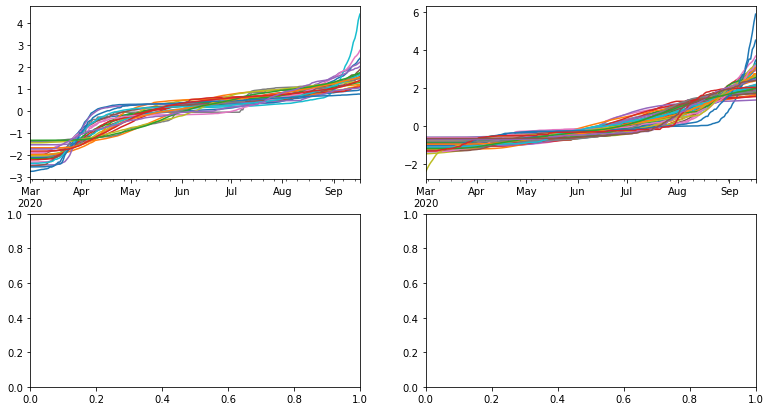

In [13]:
#Make a figure with the four clusters
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_size_inches(13, 7)
df_kmeans_z_0.plot(legend='', ax=axes[0,0])
df_kmeans_z_1.plot(legend='', ax=axes[0,1])
#df_kmeans_z_2.plot(legend='', ax=axes[1,0])
#df_kmeans_z_3.plot(legend='', ax=axes[1,1])

## Selecting test countries

In [14]:
df_forecasting = pd.read_parquet('../../data/forecasting_format/dataframe_forecasting_with_features.parquet')

In [15]:
Algeria_df = df_forecasting [df_forecasting['Country'].isin(['Algeria'])]

In [16]:
test_1_df =  Algeria_df[(Algeria_df.index.date > datetime.date(2020, 9, 9)) & 
                    (Algeria_df.index.date <= datetime.date(2020, 9, 17))].copy()

In [17]:
Belgium_df = df_forecasting[df_forecasting['Country'].isin(['Belgium'])]

In [18]:
test_2_df =  Belgium_df[(Belgium_df.index.date > datetime.date(2020, 9, 9)) & 
                    (Belgium_df.index.date <= datetime.date(2020, 9, 17))].copy()

In [19]:
Bangladesh_df = df_forecasting[df_forecasting['Country'].isin(['Bangladesh'])]

In [20]:
test_3_df =  Bangladesh_df[(Bangladesh_df.index.date > datetime.date(2020, 9, 9)) & 
                    (Bangladesh_df.index.date <= datetime.date(2020, 9, 17))].copy()

In [21]:
Croatia_df = df_forecasting[df_forecasting['Country'].isin(['Croatia'])]

In [22]:
test_4_df =  Croatia_df[(Croatia_df.index.date > datetime.date(2020, 9, 9)) & 
                    (Croatia_df.index.date <= datetime.date(2020, 9, 17))].copy()

In [23]:
selected_clusters = []
test_countries_not_used = []

In [24]:
def forecasting(k_means_countries_list,k_means_df,country_df,test_df):
    k_means_df = df_forecasting[df_forecasting['Country'].isin(k_means_countries_list)]
    k_means_training_df = k_means_df[(k_means_df.index.date >= datetime.date(2020, 3, 1)) & 
                    (k_means_df.index.date <= datetime.date(2020, 9, 9))].copy()
    feature_list = ['Country','Month','Day','prev_case']
    params= {'iterations': 5000, 'silent': True}
    model = CatBoostRegressor(**params)
    k_means_CB_df = predict_horizon(model=model, training_df=k_means_training_df.copy(), 
                                                             test_df=test_df.copy(),
                                                             feature_list=feature_list)
    k_means_CB_df = accumulated_dataframe_column(country_df,k_means_CB_df)
    return k_means_CB_df

## K-means z trans, cluster with Algeria

Select correct cluster

In [25]:
if 'Algeria' in df_kmeans_z_0.columns and 'df_kmeans_z_0' not in selected_clusters:
    k_means_1_df = df_kmeans_z_0.copy()
    selected_clusters.append('df_kmeans_z_0')
elif 'Algeria' in df_kmeans_z_1.columns and 'df_kmeans_z_1' not in selected_clusters:
    k_means_1_df = df_kmeans_z_1.copy()
    selected_clusters.append('df_kmeans_z_1')
elif 'Algeria' in df_kmeans_z_2.columns and 'df_kmeans_z_2' not in selected_clusters:
    k_means_1_df = df_kmeans_z_2.copy()
    selected_clusters.append('df_kmeans_z_2')
elif 'Algeria' in df_kmeans_z_3.columns and 'df_kmeans_z_3' not in selected_clusters:
    k_means_1_df = df_kmeans_z_3.copy()
    selected_clusters.append('df_kmeans_z_3')
else:
    test_countries_not_used.append('Algeria')

In [26]:
print(selected_clusters)
print(test_countries_not_used)

['df_kmeans_z_1']
[]


In [27]:
if 'Algeria' not in test_countries_not_used:
    k_means_1_countries_list = list(k_means_1_df.columns)
    k_means_1_CB_df = forecasting(k_means_1_countries_list,k_means_1_df,Algeria_df,test_1_df)

In [28]:
print(k_means_1_countries_list)

['Algeria', 'Argentina', 'Australia', 'Bangladesh', 'Bolivia', 'Bulgaria', 'Chile', 'Colombia', 'Costa Rica', 'Croatia', 'Czech Republic', 'Dominican Republic', 'El Salvador', 'Ethiopia', 'Ghana', 'Greece', 'India', 'Indonesia', 'Iran', 'Iraq', 'Israel', 'Japan', 'Kazakhstan', 'Kenya', 'Kuwait', 'Malawi', 'Malta', 'Mexico', 'Morocco', 'Mozambique', 'Myanmar', 'Nepal', 'Nigeria', 'Oman', 'Pakistan', 'Panama', 'Paraguay', 'Peru', 'Philippines', 'Poland', 'Romania', 'Russia', 'Rwanda', 'Saudi Arabia', 'Senegal', 'Serbia', 'Slovakia', 'South Africa', 'South Korea', 'Togo', 'Tunisia', 'Ukraine', 'United States', 'Vietnam', 'Zambia', 'Zimbabwe']


In [29]:
print(len(k_means_1_countries_list))

56


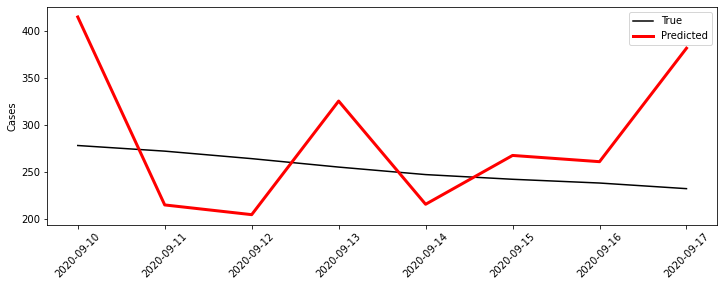

In [30]:
title_str =''
true_predicted_fig(test_1_df,k_means_1_CB_df,title_str)

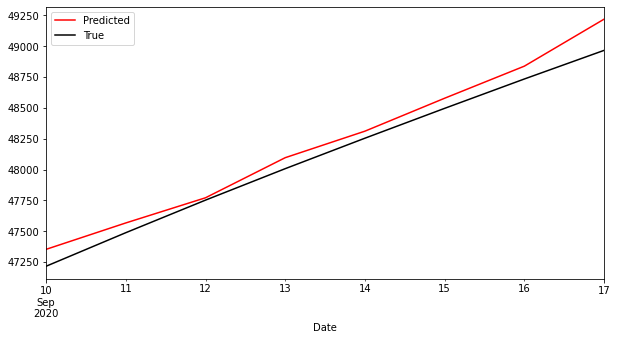

In [31]:
k_means_1_CB_df.plot( y=['Accumulated_Prediction', 'cases_tot'], label=['Predicted','True'], color=['red','black'], figsize=(10,5))

MAPE k_means 1:

In [32]:
round(MAPE(k_means_1_CB_df,'cases_tot','Accumulated_Prediction'),4)

0.2124

## K-means z trans, cluster with Belgium

Select correct cluster

In [33]:
if 'Belgium' in df_kmeans_z_0.columns and 'df_kmeans_z_0' not in selected_clusters:
    k_means_2_df = df_kmeans_z_0.copy()
    selected_clusters.append('df_kmeans_z_0')
elif 'Belgium' in df_kmeans_z_1.columns and 'df_kmeans_z_1' not in selected_clusters:
    k_means_2_df = df_kmeans_z_1.copy()
    selected_clusters.append('df_kmeans_z_1')
elif 'Belgium' in df_kmeans_z_2.columns and 'df_kmeans_z_2' not in selected_clusters:
    k_means_2_df = df_kmeans_z_2.copy()
    selected_clusters.append('df_kmeans_z_2')
elif 'Belgium' in df_kmeans_z_3.columns and 'df_kmeans_z_3' not in selected_clusters:
    k_means_2_df = df_kmeans_z_3.copy()
    selected_clusters.append('df_kmeans_z_3')
else:
    test_countries_not_used.append('Belgium')

In [34]:
print(selected_clusters)
print(test_countries_not_used)

['df_kmeans_z_1', 'df_kmeans_z_0']
[]


In [35]:
if 'Belgium' not in test_countries_not_used:
    k_means_2_countries_list = list(k_means_2_df.columns)
    k_means_2_CB_df = forecasting(k_means_2_countries_list,k_means_2_df,Belgium_df,test_2_df)

In [36]:
print(k_means_2_countries_list)

['Austria', 'Belarus', 'Belgium', 'Canada', 'Cuba', 'Denmark', 'Estonia', 'Fiji', 'Finland', 'Hungary', 'Iceland', 'Ireland', 'Latvia', 'Malaysia', 'New Zealand', 'Norway', 'Slovenia', 'Sri Lanka', 'Sweden', 'Switzerland', 'Thailand', 'Turkey', 'United Arab Emirates', 'United Kingdom', 'Uruguay']


In [37]:
print(len(k_means_2_countries_list))

25


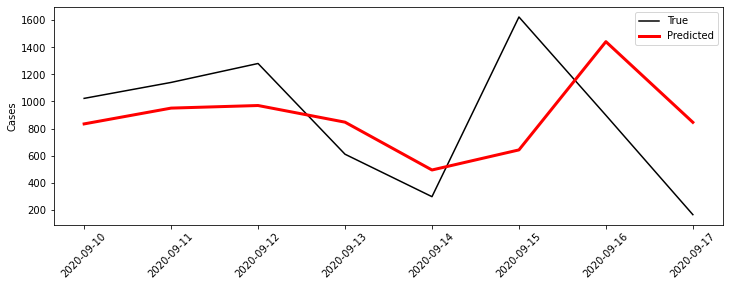

In [38]:
title_str =''
true_predicted_fig(test_2_df,k_means_2_CB_df,title_str)

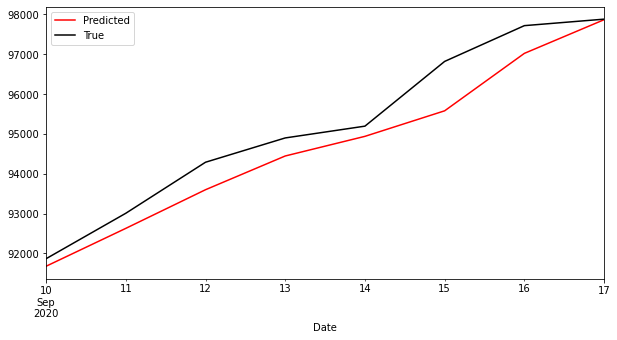

In [39]:
k_means_2_CB_df.plot( y=['Accumulated_Prediction', 'cases_tot'], label=['Predicted','True'], color=['red','black'], figsize=(10,5))

MAPE k_means 2:

In [40]:
round(MAPE(k_means_2_CB_df,'cases_tot','Accumulated_Prediction'),4)

0.5123

## K-means z trans, cluster with Bangladesh

Select correct cluster

In [41]:
if 'Bangladesh' in df_kmeans_z_0.columns: #and 'df_kmeans_z_0' not in selected_clusters:
    k_means_3_df = df_kmeans_z_0.copy()
    selected_clusters.append('df_kmeans_z_0')
elif 'Bangladesh' in df_kmeans_z_1.columns: # and 'df_kmeans_z_1' not in selected_clusters:
    k_means_3_df = df_kmeans_z_1.copy()
    selected_clusters.append('df_kmeans_z_1')
elif 'Bangladesh' in df_kmeans_z_2.columns: # and 'df_kmeans_z_2' not in selected_clusters:
    k_means_3_df = df_kmeans_z_2.copy()
    selected_clusters.append('df_kmeans_z_2')
elif 'Bangladesh' in df_kmeans_z_3.columns: # and 'df_kmeans_z_3' not in selected_clusters:
    k_means_3_df = df_kmeans_z_3.copy()
    selected_clusters.append('df_kmeans_z_3')
else:
    test_countries_not_used.append('Bangladesh')

In [42]:
print(selected_clusters)
print(test_countries_not_used)

['df_kmeans_z_1', 'df_kmeans_z_0', 'df_kmeans_z_1']
[]


In [43]:
if 'Bangladesh' not in test_countries_not_used:
    k_means_3_countries_list = list(k_means_3_df.columns)
    k_means_3_CB_df = forecasting(k_means_3_countries_list,k_means_3_df,Bangladesh_df,test_3_df)

In [44]:
print(k_means_3_countries_list)

['Algeria', 'Argentina', 'Australia', 'Bangladesh', 'Bolivia', 'Bulgaria', 'Chile', 'Colombia', 'Costa Rica', 'Croatia', 'Czech Republic', 'Dominican Republic', 'El Salvador', 'Ethiopia', 'Ghana', 'Greece', 'India', 'Indonesia', 'Iran', 'Iraq', 'Israel', 'Japan', 'Kazakhstan', 'Kenya', 'Kuwait', 'Malawi', 'Malta', 'Mexico', 'Morocco', 'Mozambique', 'Myanmar', 'Nepal', 'Nigeria', 'Oman', 'Pakistan', 'Panama', 'Paraguay', 'Peru', 'Philippines', 'Poland', 'Romania', 'Russia', 'Rwanda', 'Saudi Arabia', 'Senegal', 'Serbia', 'Slovakia', 'South Africa', 'South Korea', 'Togo', 'Tunisia', 'Ukraine', 'United States', 'Vietnam', 'Zambia', 'Zimbabwe']


In [45]:
if 'Bangladesh' not in test_countries_not_used:
    print(len(k_means_3_countries_list))

56


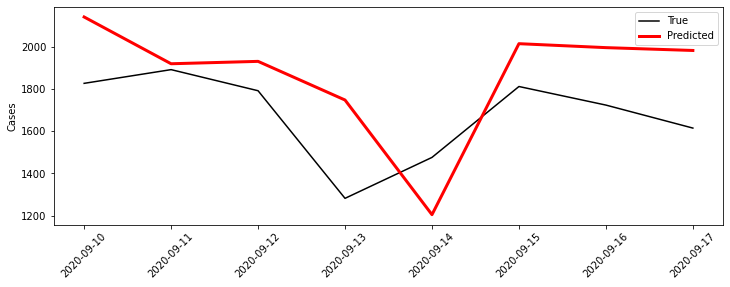

In [46]:
if 'Bangladesh' not in test_countries_not_used:
    title_str =''
    true_predicted_fig(test_3_df,k_means_3_CB_df,title_str)

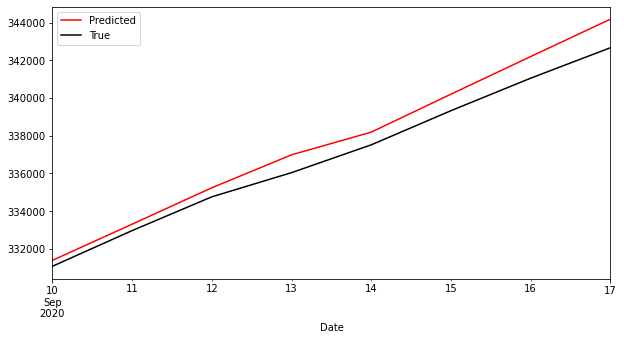

In [47]:
if 'Bangladesh' not in test_countries_not_used:
    k_means_3_CB_df.plot( y=['Accumulated_Prediction', 'cases_tot'], label=['Predicted','True'], color=['red','black'], figsize=(10,5))

MAPE k_means 3:

In [48]:
round(MAPE(k_means_3_CB_df,'cases_tot','Accumulated_Prediction'),4)

0.2323

## K-means z trans, cluster with Croatia

Select correct cluster

In [49]:
if 'Croatia' in df_kmeans_z_0.columns: # and 'df_kmeans_z_0' not in selected_clusters:
    k_means_4_df = df_kmeans_z_0.copy()
    selected_clusters.append('df_kmeans_z_0')
elif 'Croatia' in df_kmeans_z_1.columns: # and 'df_kmeans_z_1' not in selected_clusters:
    k_means_4_df = df_kmeans_z_1.copy()
    selected_clusters.append('df_kmeans_z_1')
elif 'Croatia' in df_kmeans_z_2.columns: # and 'df_kmeans_z_2' not in selected_clusters:
    k_means_4_df = df_kmeans_z_2.copy()
    selected_clusters.append('df_kmeans_z_2')
elif 'Croatia' in df_kmeans_z_3.columns: # and 'df_kmeans_z_3' not in selected_clusters:
    k_means_4_df = df_kmeans_z_3.copy()
    selected_clusters.append('df_kmeans_z_3')
else:
    test_countries_not_used.append('Croatia')

In [50]:
print(selected_clusters)
print(test_countries_not_used)

['df_kmeans_z_1', 'df_kmeans_z_0', 'df_kmeans_z_1', 'df_kmeans_z_1']
[]


In [51]:
if 'Croatia' not in test_countries_not_used:
    k_means_4_countries_list = list(k_means_4_df.columns)
    k_means_4_CB_df = forecasting(k_means_4_countries_list,k_means_4_df,Croatia_df,test_4_df)

In [52]:
print(k_means_4_countries_list)

['Algeria', 'Argentina', 'Australia', 'Bangladesh', 'Bolivia', 'Bulgaria', 'Chile', 'Colombia', 'Costa Rica', 'Croatia', 'Czech Republic', 'Dominican Republic', 'El Salvador', 'Ethiopia', 'Ghana', 'Greece', 'India', 'Indonesia', 'Iran', 'Iraq', 'Israel', 'Japan', 'Kazakhstan', 'Kenya', 'Kuwait', 'Malawi', 'Malta', 'Mexico', 'Morocco', 'Mozambique', 'Myanmar', 'Nepal', 'Nigeria', 'Oman', 'Pakistan', 'Panama', 'Paraguay', 'Peru', 'Philippines', 'Poland', 'Romania', 'Russia', 'Rwanda', 'Saudi Arabia', 'Senegal', 'Serbia', 'Slovakia', 'South Africa', 'South Korea', 'Togo', 'Tunisia', 'Ukraine', 'United States', 'Vietnam', 'Zambia', 'Zimbabwe']


In [53]:
print(len(k_means_4_countries_list))

56


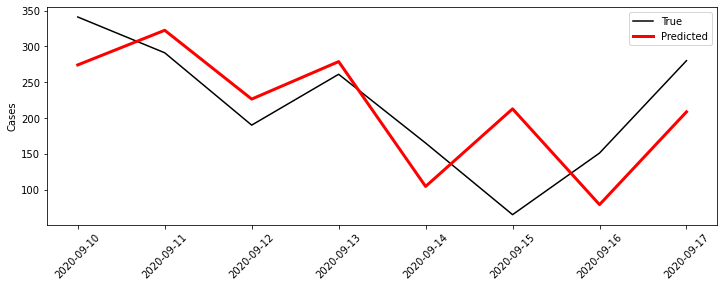

In [54]:
title_str =''
true_predicted_fig(test_4_df,k_means_4_CB_df,title_str)

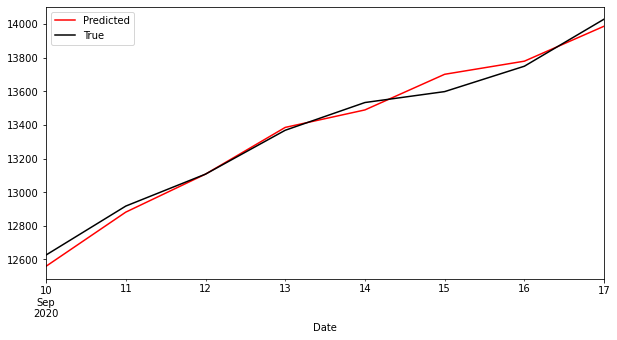

In [55]:
k_means_4_CB_df.plot( y=['Accumulated_Prediction', 'cases_tot'], label=['Predicted','True'], color=['red','black'], figsize=(10,5))

MAPE k_means 4:

In [56]:
round(MAPE(k_means_4_CB_df,'cases_tot','Accumulated_Prediction'),4)

0.3171

Total MAPE

In [57]:
round(MAPE(k_means_1_CB_df,'cases_tot','Accumulated_Prediction'),4)+round(MAPE(k_means_2_CB_df,'cases_tot','Accumulated_Prediction'),4)+round(MAPE(k_means_3_CB_df,'cases_tot','Accumulated_Prediction'),4)+round(MAPE(k_means_4_CB_df,'cases_tot','Accumulated_Prediction'),4)

1.2741